# Partie 2 : Analyse descriptive et représentation graphique 

Cette deuxième partie s'intéresse à l'analyse descriptive de la base de données obtenue précédemment. Visualiser graphiquement nos données nous permettra de lier les conditions météorologiques à l'occurence de feux de forêt et à leur intensité (en termes de surface brûlée). 




Nous utiliserons pour cela plusieurs niveaux de représentation. 


*   Dans un premier temps, nous allons localiser les feux de forêt sur le territoire métropolitain. 
*   Ensuite, nous comparerons les données météorologiques suivant qu'il y ait eu ou non un départ de feux, afin d'identifier les conditions propices au déclenchement d'un feu de forêt. 
*   Enfin, nous nous intéresserons à la superficie de surface brûlée en fonction des conditions météorologiques.









# A. Où sont situés les feux de forêt sur le territoire ?


Nous allons, dans cette partie du projet, représenter les données sur des cartes de France métropolitaine. Nous utiliserons pour cela *GeoPandas*

In [1]:
#!pip install geopandas
#!pip install contextily

     |████████████████████████████████| 972kB 6.6MB/s 
     |████████████████████████████████| 6.5MB 9.5MB/s 
     |████████████████████████████████| 14.8MB 282kB/s 
     |████████████████████████████████| 18.3MB 46.7MB/s 


In [21]:
import requests
import tempfile
import zipfile
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

In [ ]:
import contextily as ctx
#on le met dans une cellule à part car l'installation de contextily ne marche pas sur tous les ordinateurs

## Préparation des données spatiales 

Afin de construire des cartes de France métropolitaine lisibles, nous allons prendre comme échelle minimale les départements. Nous devons ainsi préparer la base de données correspondantes.














*   Dans un premier temps, nous récupérons les **données administratives de limites départementales** de France métropolitaine à partir du site *data.gouv*.






In [44]:
url = "https://www.data.gouv.fr/fr/datasets/r/eb36371a-761d-44a8-93ec-3d728bec17ce" 
dep_borders = gpd.read_file(url)
dep_borders = dep_borders[dep_borders.code_insee.str[:2]!= "97"]

In [45]:
dep_borders.head()

,code_insee,nom,nuts3,wikipedia,surf_km2,geometry
1,11,Aude,FR811,fr:Aude (département),6343.0,"POLYGON ((1.68872 43.27368, 1.69001 43.27423, ..."
2,43,Haute-Loire,FR723,fr:Haute-Loire,5003.0,"POLYGON ((3.08206 45.28988, 3.08209 45.29031, ..."
3,13,Bouches-du-Rhône,FR823,fr:Bouches-du-Rhône,5247.0,"MULTIPOLYGON (((4.23014 43.46047, 4.23025 43.4..."
4,47,Lot-et-Garonne,FR614,fr:Lot-et-Garonne,5385.0,"POLYGON ((-0.14058 44.22648, -0.12931 44.23218..."
5,23,Creuse,FR632,fr:Creuse (département),5599.0,"POLYGON ((1.37254 46.21672, 1.37257 46.21677, ..."


En regardant la base *dep_borders*, nous observons une anomalie sur le bassin lyonnais, où la base de données fait la distinction entre le département du Rhône et la métropole de Lyon. Cette distinction ne sera pas faite dans les bases de données que nous utiliserons par la suite, nous allons donc fusionner ces deux lignes.






In [46]:
dep_borders[dep_borders.code_insee.str[:2]== "69"]

,code_insee,nom,nuts3,wikipedia,surf_km2,geometry
63,69D,Rhône,None,fr:Rhône (département),2720.0,"MULTIPOLYGON (((4.24364 45.99721, 4.24367 45.9..."
64,69M,Métropole de Lyon,FR716,fr:Métropole de Lyon,538.0,"POLYGON ((4.69174 45.78845, 4.69193 45.78851, ..."


Nous allons utiliser pour fusionner les deux géométries la *fonction dissolve de GeoPandas*. Néanmoins, cette fonction n'aura un effet que sur les données géométriques. Nous devons donc sommer les surfaces des deux départements et modifier les autres données à la main.

In [47]:
surface = dep_borders["surf_km2"][dep_borders.code_insee.str[:2]== "69"].sum()
dep_borders["surf_km2"][dep_borders.code_insee.str[:2]== "69"] = surface
dep_borders["nom"][dep_borders.code_insee.str[:2]== "69"] = "Rhône"
dep_borders["code_insee"][dep_borders.code_insee.str[:2]== "69"] = "69" 

In [48]:
dep_borders[dep_borders.code_insee.str[:2]== "69"]

,code_insee,nom,nuts3,wikipedia,surf_km2,geometry
63,69,Rhône,None,fr:Rhône (département),3258.0,"MULTIPOLYGON (((4.24364 45.99721, 4.24367 45.9..."
64,69,Rhône,FR716,fr:Métropole de Lyon,3258.0,"POLYGON ((4.69174 45.78845, 4.69193 45.78851, ..."


In [49]:
dep_borders["dép_doublon"] = dep_borders.code_insee.str[:2]
dép_borders = dep_borders.dissolve(by='dép_doublon')


*   Ensuite, nous aggrégeons les **données sur les feux** (obtenues dans la partie I) **par département**.

Nous ne gardons comme variables que celles qui nous semblent intéressantes pour une représentation cartographique. 



In [50]:
df = pd.read_csv('data.zip', low_memory = False)
df = df[df['Départ de feu'] == 1]
#on ne conserve que les données correspondantes à un départ de feu. 

On aggrége les données sur les feux par département et gardons les variables que nous trouvons intéressantes. L'on crée de plus une nouvelle variable *Surface moyenne* qui est, pour chaque département, le quotient de la surface brûlée totale et du nombre de feux. 

In [51]:
dép_agg = df.groupby('Département').agg({"Surface brûlée (m2)": "sum",
                                         "Date de première alerte" : "count",

                                                   }).reset_index()
                                                   
dép_agg = dép_agg[dép_agg.Département.str[:2]!= "97"]
dép_agg = dép_agg.rename(columns={'Date de première alerte':'Nombre de feux'})
dép_agg["Surface moyenne"] = dép_agg["Surface brûlée (m2)"] / dép_agg["Nombre de feux"]

dép_agg

,Département,Surface brûlée (m2),Nombre de feux,Surface moyenne
0,01,1362000.0,45,30266.666667
1,02,104015.0,9,11557.222222
2,03,670300.0,11,60936.363636
3,04,20000080.0,618,32362.588997
4,05,3022115.0,113,26744.380531
...,...,...,...,...
79,89,132100.0,9,14677.777778
80,90,8980.0,2,4490.000000
81,91,657200.0,4,164300.000000
82,94,20000.0,1,20000.000000


La base de données des feux nous informe que seulement 84 départements ont été victimes de feux de forêt depuis 2006. Certains départements n'ont en effet pas connu de feux de forêt. Ces informations sont à rajouter dans la base afin d'obtenir des cartes complétes.






In [52]:
no_fires = dép_borders[~dép_borders["code_insee"].isin(dép_agg["Département"])]

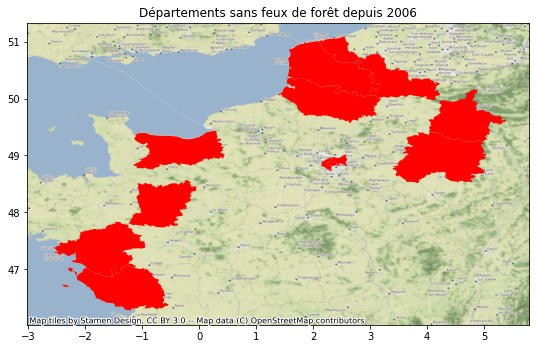

In [11]:
#attention : il faut contextily pour cette cellule
ax = no_fires.plot(color="red", figsize=(9, 9))
plt.title("Départements sans feux de forêt depuis 2006")
ctx.add_basemap(ax, crs=no_fires.crs.to_string())

Les départements en rouge sur la carte sont ceux où il n'y a aucun feux de forêt depuis 2006. On voit qu'ils sont situés majoritairement dans le Nord de la France (Nord-Pas-de-Calais, Champagne-Ardenne, Normandie par exemple). Il n'y a également pas de feux de forêt au nord de la métropôle parisienne.





L'on crée un nouveau dataframe, contenant les numéros des départements non-victimes de feux. On ajoute les variables *Surface brûlée (m2)* et *Nombre de feux* qu'on sait nulles. Nous n'avons néanmoins pas d'informations sur la variable *Surface moyenne*, qui est indéterminée (S'il y avait des feux, quelles seraient leurs surfaces ?). 

Ensuite, on concaténe ce dataframe avec le dataframe *dép_agg*, qui contiendra dès lors des informations sur tous les départements de France métropolitaine.







In [53]:
dép_no_fires = pd.DataFrame({'Département': [ x for x in no_fires["code_insee"]], 
                        'Surface brûlée (m2)': [0] * len(no_fires.index), 
                        'Nombre de feux': [0] * len(no_fires.index)} )

In [54]:
dép_agg = pd.concat([dép_agg, dép_no_fires])

In [55]:
dép_agg

,Département,Surface brûlée (m2),Nombre de feux,Surface moyenne
0,01,1362000.0,45,30266.666667
1,02,104015.0,9,11557.222222
2,03,670300.0,11,60936.363636
3,04,20000080.0,618,32362.588997
4,05,3022115.0,113,26744.380531
...,...,...,...,...
7,75,0.0,0,NaN
8,80,0.0,0,NaN
9,85,0.0,0,NaN
10,92,0.0,0,NaN




*   Enfin, pour chaque département, nous créons des **variables météorologiques** (températures maximales et moyennes depuis janvier 2018).






---



In [56]:
météo_jour = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/dd0df06a-85f2-4621-8b8b-5a3fe195bcd7",sep = ';')

météo_jour.head()

,date_obs,code_insee_departement,departement,tmin,tmax,tmoy
0,2019-12-31,87,Haute-Vienne,2.30,10.00,6.15
1,2019-12-31,19,Corrèze,-2.70,10.90,4.10
2,2019-12-31,83,Var,4.77,14.08,9.43
3,2019-12-31,27,Eure,-3.10,5.50,1.20
4,2019-12-31,23,Creuse,-4.50,13.20,4.35


La base *météo_jour* présente les températures maximales, minimales et moyennes quotidiennes (en degré celsius), par département administratif depuis le 1er janvier 2018. 




In [57]:
météo_dep = météo_jour.groupby('code_insee_departement').agg({"tmax": "max", "tmoy" : "mean"}).reset_index()

Enfin, nous fusionnons les différentes bases, afin d'obtenir une base de données géographiques (géodataframe).


In [58]:
data_dep = pd.merge(dép_agg, météo_dep, how = 'inner', left_on = 'Département', right_on = 'code_insee_departement')
data_dep.head()

,Département,Surface brûlée (m2),Nombre de feux,Surface moyenne,code_insee_departement,tmax,tmoy
0,01,1362000.0,45,30266.666667,01,38.4,13.029427
1,02,104015.0,9,11557.222222,02,40.7,11.962808
2,03,670300.0,11,60936.363636,03,41.3,13.074113
3,04,20000080.0,618,32362.588997,04,42.2,14.425408
4,05,3022115.0,113,26744.380531,05,38.4,12.430601


In [59]:
dép = dép_borders.merge(data_dep,left_on="code_insee", right_on="Département")
dép = dép.drop(columns = ['code_insee_departement','nuts3','wikipedia','Département'])

In [60]:
dép.head()

,geometry,code_insee,nom,surf_km2,Surface brûlée (m2),Nombre de feux,Surface moyenne,tmax,tmoy
0,"POLYGON ((4.72817 45.94598, 4.72824 45.94758, ...",01,Ain,5784.0,1362000.0,45,30266.666667,38.4,13.029427
1,"POLYGON ((2.95795 49.22691, 2.95796 49.22700, ...",02,Aisne,7411.0,104015.0,9,11557.222222,40.7,11.962808
2,"POLYGON ((2.27684 46.42491, 2.27686 46.42497, ...",03,Allier,7379.0,670300.0,11,60936.363636,41.3,13.074113
3,"POLYGON ((5.49642 44.10309, 5.49726 44.10367, ...",04,Alpes-de-Haute-Provence,6993.0,20000080.0,618,32362.588997,42.2,14.425408
4,"POLYGON ((5.41839 44.42476, 5.41852 44.42493, ...",05,Hautes-Alpes,5697.0,3022115.0,113,26744.380531,38.4,12.430601


Le dataframe *dép* obtenu est un objet géographique, ce qui nous permettra de représenter les données au moyen de cartes.



## Observations sur des cartes



*   Dans un premier temps, on regarde la **répartition du nombre de feux, de la surface brûlée et de la surface moyenne brûlée par feux** sur toute la France. 


Text(0.5, 1.0, 'Répartition des feux par département')

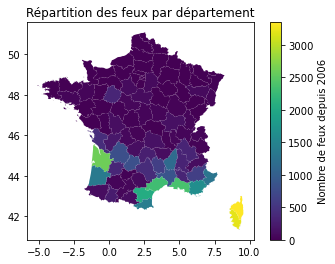

In [61]:
dép.plot(column="Nombre de feux", legend = True,legend_kwds={'label': "Nombre de feux depuis 2006"})
plt.title("Répartition des feux par département")

Le nombre de feux est inégalement réparti sur le territoire de France métropolitaine. Le Sud de la France est très touché : les départements du bassin méditérranéen ont environ connu 2000 feux chacun depuis 2006. La zone la plus touchée est la Corse (Haute-Corse et Corse-du-Sud), avec environ 6000 feux de forêts en 13 ans. 

A l'inverse le centre et le nord de la France semblent relativement épargnés par les feux de forêts : chaque département a environ connu 500 feux de forêts en 13 ans, soit quatre fois moins que dans le Sud de la France. 



Text(0.5, 1.0, 'Surface brûlée par département')

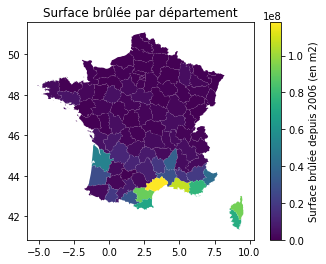

In [62]:
dép.plot(column = "Surface brûlée (m2)", legend = True, legend_kwds={'label': "Surface brûlée depuis 2006 (en m2)"})
plt.title("Surface brûlée par département")

On retrouve également des disparités départementales dans la surface totale brûlée. 
Les départements du Sud de la France (et plus particulièrement du bassin méditérranéen) ont eu environ $80  km^2$ de territoire brûlé entre 2006 et 2019, tandis que dans le Nord et dans le Centre de la France, la surface totale brûlée est d'environ $10 km^2$ par département. 





Text(0.5, 1.0, "Surface moyenne d'un feu par département")

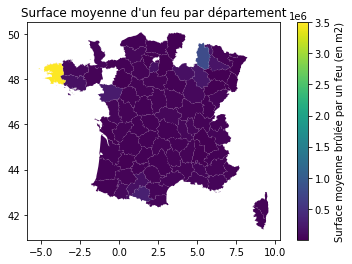

In [63]:
dép.plot(column ="Surface moyenne",legend=True,legend_kwds={'label': "Surface moyenne brûlée par un feu (en m2)"})
plt.title("Surface moyenne d'un feu par département")

Les départements manquants sont ceux où il n'y a pas eu de feux de forêt.

La surface moyenne de forêt brûlée par chaque feu est relativement homogène dans tous les départements. En moyenne, chaque feu semble brûler moins de $0,5 km^2$ de forêt. On remarque que la Bretagne sort du lot, c'est dû à un très faible nombre de feux dans cette région mais qui ont été dévastateurs donc la moyenne est élevée.


Ces cartes expliquent que les départements ayant eu le plus de feux de forêt (respectivement le moins) sont également ceux avec la plus grande surface totale de forêt brûlée (respectivement la plus petite).



*   Nous allons maintenant observer ces résultat sur la répartition des feux au regard des **conditions météorologiques** des départements.





Text(0.5, 1.0, 'Température moyenne par département')

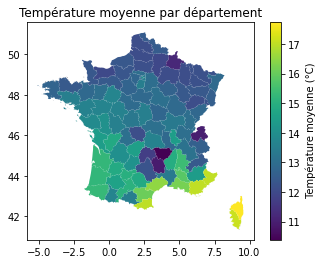

In [64]:
dép.plot(column = "tmoy",legend=True,legend_kwds={'label': " Température moyenne (°C)"})
plt.title("Température moyenne par département")

Les départements avec la température moyenne la plus élevée sont dans le Sud de la France : il fait en moyenne presque 17° dans le bassin méditerranéen et en Corse, et plus de 15° dans les Landes, alors qu'il fait environ 13° dans les départements les plus au Nord. 

On remarque que les départements avec une température moyenne parmi les plus élevées sont également ceux avec un nombre de feux le plus important. A l'inverse, les départements les plus froids ont connu bien moins de feux de forêt. Il semble donc qu'il y ait une corrélation entre la température moyenne et le risque de feux de forêt. 


Text(0.5, 1.0, 'Température maximale depuis 2006 par département')

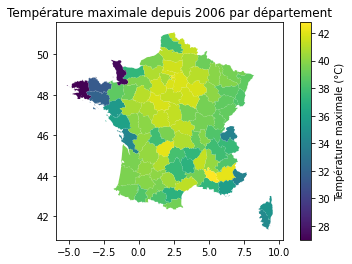

In [66]:
dép.plot(column = "tmax",legend=True,legend_kwds={'label': "Température maximale (°C)"})
plt.title("Température maximale depuis 2006 par département")

La répartition des températures maximales par département est très différente de ce que l'on a pu observé dans les cartes précédentes. Les départements où il a fait le plus chaud sont situés dans le Centre de la France, qui ont déjà atteint les 42°. La température maximale est plus basse dans les départements situés sur les côtes françaises. La Bretagne atteint un maximum à 28°, et même la Corse n'excède pas les 38°.

Il apparaît qu'il n'y a pas de corrélation entre la température maximale mesurée dans le département et le nombre de feux de forêt. La température maximale observée depuis 13 ans n'est en fait pas un bon indicateur des réalités climatologiques des départements. 

Par exemple, une température maximale de 40° en Picardie paraît **anecdotique**, alors que les départements de cette région ont une température moyenne de 13° : il a pu faire très chaud au moment d'un relevé de température, sans que cela ne se ressente sur les conditions climatiques le reste du temps.






En conclusion, représenter les données par les cartes met en avant la répartition territoriale des feux de forêt. Ceux-ci sont surtout courants dans le Sud de la France. La répartition des feux de forêt concorde avec celle des températures moyennes. L'on pressent ainsi que le déclenchement d'un feu est liée positivement à la température. Cette hypothèse est explorée dans la seconde partie, qui compare les conditions météorologiques suivant qu'il y ait eu un départ de feu ou non. 




# B. La météo propice à un départ de feu 

Dans cette partie, nous comparerons les conditions météorologiques moyennes lors d'un départ de feu de celles observées le reste du temps. 

Tout d'abord, on **sépare en deux la base** obtenue dans la partie 1 suivant qu'il s'agisse des données correspondant à un départ de feu (ici *df_feu*) ou non (ici *df_non_feu*). 

In [67]:
df = pd.read_csv('data.zip') 

C:\Users\theoc\anaconda3\envs\ML\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (2,3,4,5,6,15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [69]:
df_not_feu = df[df['Départ de feu'] == 0]
df_not_feu = df_not_feu.sort_values(['Date'])
df_not_feu = df_not_feu.reset_index(drop = True)
df_not_feu = df_not_feu.iloc[:,[21,22,23,24]]  #les variables de météo correspondent aux colonnes 21 à 24
df_not_feu.head()

,Température (°C),Précipitations (3 heures),Humidité (%),Vitesse du vent (m/s)
0,4.0,2.0,92.0,5.1
1,3.7,0.0,92.0,4.1
2,23.5,NaN,95.0,0.0
3,26.1,NaN,93.0,2.1
4,2.8,0.2,91.0,5.1


In [70]:
df_feu = df[df['Départ de feu'] == 1]
df_feu = df_feu.drop(columns = ['Départ de feu'])
df_feu = df_feu.sort_values(['Date de première alerte'])
df_feu = df_feu.reset_index(drop = True)
df_feu.head()

,Année,Date de première alerte,Département,Commune,Code postal,Code INSEE,Latitude commune,Longitude commune,Surface brûlée (m2),Surface forêt (m2),...,Station la plus proche,id_station,Latitude station,Longitude station,Altitude station,Date,Température (°C),Précipitations (3 heures),Humidité (%),Vitesse du vent (m/s)
0,2006.0,2006-01-01 12:50:00,66,SAINT LAURENT DE CERDANS,66260,66179,42.3833,2.61667,10000.0,10000.0,...,PERPIGNAN,7747.0,42.737167,2.872833,42.0,2006-01-01 12:00:00,11.7,0.0,50.0,8.7
1,2006.0,2006-01-01 12:56:00,66,SALSES LE CHATEAU,66600,66190,42.8328,2.91889,20000.0,0.0,...,PERPIGNAN,7747.0,42.737167,2.872833,42.0,2006-01-01 12:00:00,11.7,0.0,50.0,8.7
2,2006.0,2006-01-01 15:40:00,83,CALLAS,83830,83028,43.5833,6.53333,30.0,30.0,...,NICE,7690.0,43.648833,7.209000,2.0,2006-01-01 15:00:00,10.4,0.0,76.0,6.2
3,2006.0,2006-01-02 18:19:00,34,ROUJAN,34320,34237,43.5167,3.30000,37500.0,10000.0,...,MONTPELLIER,7643.0,43.577000,3.963167,2.0,2006-01-02 18:00:00,7.5,0.0,54.0,4.1
4,2006.0,2006-01-02 20:57:00,83,DRAGUIGNAN,83300,83050,43.5333,6.46667,200.0,200.0,...,NICE,7690.0,43.648833,7.209000,2.0,2006-01-02 21:00:00,6.8,0.0,64.0,4.1


On peut maintenant comparer les données météoroligues des deux dataframes. On a des informations quantitatives sur la température, les précipitations durant les trois dernières heures, l'humidité et la vitesse du vent.

## Première approche : comparaison des moyennes



Feu


Température (°C)             21.119288
Précipitations (3 heures)     0.079135
Humidité (%)                 52.560059
Vitesse du vent (m/s)         4.542621
dtype: float64


Pas de feu


Température (°C)             14.689329
Précipitations (3 heures)     0.331593
Humidité (%)                 76.184232
Vitesse du vent (m/s)         4.126053
dtype: float64

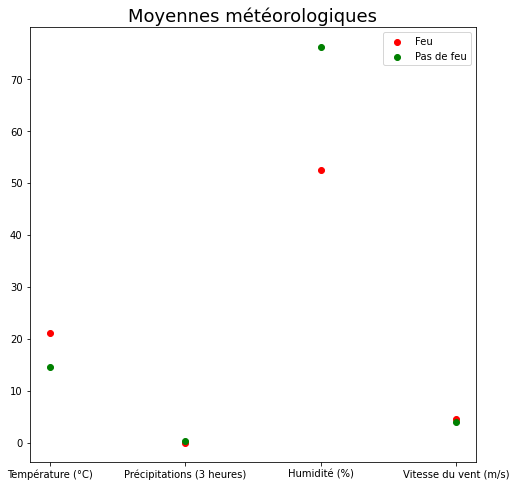

In [71]:
var_meteo = ['Température (°C)', 'Précipitations (3 heures)', 'Humidité (%)', 'Vitesse du vent (m/s)']

y1 = list(df_feu.iloc[:,[20,21,22,23]].mean())
print('Feu')
display(df_feu.iloc[:,[20,21,22,23]].mean())

print('')

y2 = list(df_not_feu.mean())
print('Pas de feu')
display(df_not_feu.mean())

plt.figure(figsize = (8,8))
plt.scatter(var_meteo, y1, c = 'red')
plt.scatter(var_meteo, y2, c = 'green')
plt.title('Moyennes météorologiques', fontsize=18)
plt.legend(['Feu', 'Pas de feu'])

En sortie du code, on trouve les moyennes des variables selon qu'il y a eu une déclaration d'incendies ou non. 

On observe ainsi qu'en moyenne, lors d'une déclaration d'incendie : 



*   La température est plus élevée de 7 degrés,
*   Il y a eu moins de précipitation dans les trois dernières heures (0.08 mm contre 0.33 mm), 
*   Il fait 24% moins humide,
*   La vitesse du vent est légérement plus élevée (4.5m/s contre 4.1 m/s).

Cela correspond bien à l'a priori qu'on pouvait en avoir : un feu de forêt a plus tendance à se déclarer lorsqu'il fait très chaud (en été par exemple), que la terre et l'air sont secs, et le vent aide à l'embrasement du feu. 





## Observation avec des diagrammes en boîte



Nous allons comparer ces 4 paramètres météorologiques plus en détail à l'aide de boîte à moustaches (ou box-plot). Ce type de diagramme permet de mieux observer la répartition des données. 



In [72]:
df_correl = df.iloc[:, [0,21,22,23,24]]
df_correl.head()

,Départ de feu,Température (°C),Précipitations (3 heures),Humidité (%),Vitesse du vent (m/s)
0,0,4.0,2.0,92.0,5.1
1,0,3.7,0.0,91.0,4.1
2,0,3.1,3.0,92.0,5.1
3,0,4.7,0.6,96.0,3.1
4,0,6.1,2.0,94.0,5.1




*   **Observations sur la température**



Text(0.5, 1.0, 'Diagrammes en boîte selon la température')

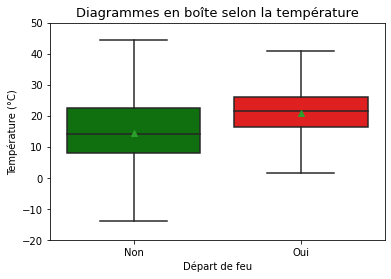

In [73]:
box = sns.boxplot(x = df_correl['Départ de feu'], y = df_correl['Température (°C)'], showmeans = True, palette = ['green', 'red'],fliersize = 0)
box.set_xticklabels(['Non', 'Oui'])
plt.ylim(-20, 50)
box.set_title("Diagrammes en boîte selon la température",fontsize=13)

On retrouve bien les résultats précédents : il fait en moyenne plus chaud au moment de la déclaration d'incendies qu'en moyenne. En comparant les écarts inter-quartiles, on remarque également que dans le cas d'un départ de feu, les températures sont moins dispersées que la répartition moyenne. 

On peut lier cette obversation à la saisonnalité des feux de forêt et des températures.

Text(0.5, 1.0, "Répartition des feux dans l'année")

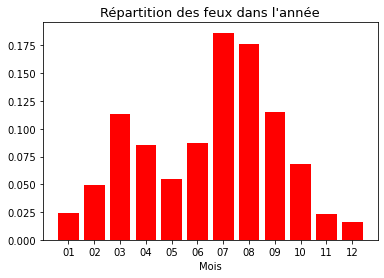

In [74]:
mois, nb_feux = np.unique(df_feu['Date de première alerte'].str[5:7], return_counts=True)
partition = nb_feux / sum(nb_feux)
plt.bar(mois, partition, color = 'r')
plt.xlabel('Mois')
plt.title("Répartition des feux dans l'année",fontsize = 13)

Les feux sont les plus fréquents durant les mois d'été (36% d'entre eux sont en juillet ou en août), c'est-à-dire les mois où il fait le plus chaud. Néanmoins, on observe que les feux n'apparaissent pas qu'en été - loin de là -, mais bien durant toute l'année. Par exemple, il y a en autant en mars qu'en septembre, alors que les températures y sont bien plus fraîches. 

Cela est cohérent avec la comparaison des diagrammes en boîte : les feux se déclenchent majoritairement lorsqu'il fait chaud (d'où des quartiles plus élevés), mais c'est une condition ni nécessaire ni suffisante. La répartition des feux selon la température n'est donc pas complétement différente de la répartition moyenne des températures.





*   **Observations sur l'humidité**




Text(0.5, 1.0, "Diagrammes en boîte selon l'humidité")

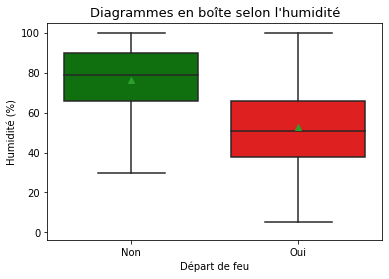

In [75]:
box = sns.boxplot(x = df_correl['Départ de feu'], y = df_correl['Humidité (%)'], showmeans = True, palette = ['green', 'red'],fliersize = 0)
box.set_xticklabels(['Non', 'Oui'])
box.set_title("Diagrammes en boîte selon l'humidité",fontsize=13)

L'humidité médiane lors du déclenchement d'un feu de forêt est bien plus basse que celle observée en temps normal. 

On peut par exemple retenir le chiffre suivant : le troisième quartile de l'humidité lors d'un feu de forêt est environ égal au premier quartile de l'humidité observée, c'est-à-dire que trois quarts des feux de forêt se déclenchent à des humidités observées moins d'un quart du temps. 




*   **Observations sur la vitesse du vent et les précipitations**



Text(0.5, 1.0, 'Diagrammes en boîte selon la vitesse du vent')

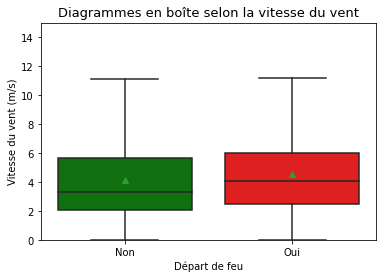

In [76]:
box = sns.boxplot(x = df_correl['Départ de feu'], y = df_correl['Vitesse du vent (m/s)'], showmeans = True, palette = ['green', 'red'], fliersize = 0,)
plt.ylim(0, 15)
box.set_xticklabels(['Non', 'Oui'])
box.set_title("Diagrammes en boîte selon la vitesse du vent",fontsize=13)

Les médiane et quartiles sont légérement plus élevés dans le cas des feux de forêt, mais l'on n'observe pas de réelles différences entre les deux distributions. Ainsi, la vitesse du vent ne semble pas être une condition déterminante du déclenchement d'un feu de forêt. 


Text(0.5, 1.0, 'Diagrammes en boîte selon les précipitations')

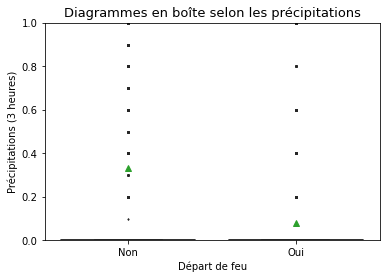

In [77]:
box = sns.boxplot(x = df_correl['Départ de feu'], y = df_correl['Précipitations (3 heures)'], showmeans = True, palette = ['green', 'red'], fliersize = 1)
plt.ylim(0, 1)
box.set_xticklabels(['Non', 'Oui'])
box.set_title("Diagrammes en boîte selon les précipitations",fontsize=13)

Les données sur les précipations sont peu exploitables : quasiment tous les relevés font état de précipitations nulles, de telle sorte que si une précipitation est non nulle, elle est une valeur aberrante (se situe en dehors de la boîte à moustache). 

En conclusion, les feux de forêt se produisent majoritairement dans un climat plus chaud et plus sec que le climat moyen observé en France métropolitaine. Néanmoins, la vitesse du vent et les précipations ne sont pas significativement différentes de ceux observées en temps normal. 

Dans les données de Météo France, il n'y avait que la colonne des précipitations des 3 dernières heures (avant le relevé) qui avait peu de NaN. Peut-être qu'avec les dernières précipitations sur 24h on pourrait obtenir une corrélation entre départ de feux et précipitations.


## Matrice de corrélation

La partie précédente nous apporte une première part de réponse quant aux conditions météorologiques propices au départ d'un feu. 

Afin d'apporter une meilleure conclusion, nous allons utiliser une matrice de corrélation. Cela nous permettra notamment de comparer entre elles les corrélations entre départ de feu et chaque variable météorologique.





Text(0.5, 1.0, 'Matrice des corrélations entre conditions météorologiques et départ de feu')

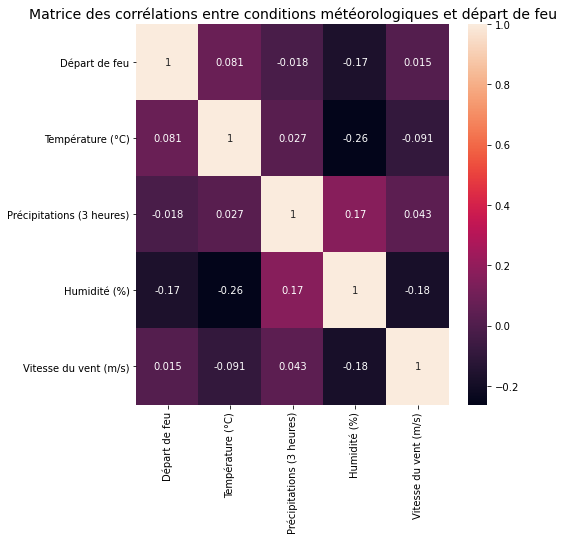

In [78]:
val = df_correl.corr()
plt.figure(figsize = (7,7))
matrice = sns.heatmap(val, annot = True)
matrice.set_title("Matrice des corrélations entre conditions météorologiques et départ de feu",fontsize=14)

On voit tout d'abord que les corrélations ne sont pas très fortes. C'est normal car il y a très peu de départs de feu. Par exemple, même si la plupart des feux partent lorsqu'il fait chaud, ce n'est pas pour autant qu'un feu part à chaque fois qu'il fait chaud (et heureusement...).
Cependant, les signes des coefficients de corrélation sont importants.

En s'appuyant sur la première colonne, on s'aperçoit que :


*   La donnée météo la plus corrélée positivement avec un départ de feu est la température (corrélation de +0.081). Plus il fait chaud, plus c'est propice à un départ de feu.

*   Il y a aussi une corrélation positive entre un départ de feu avec la vitesse du vent (de +0.015). Plus le vent souffle, plus cela aide une braise à démarrer un feu. C'est pour cela que les aventuriers de Koh-Lanta soufflent sur les braises ou qu'on utilise un soufflet pour nos fourneaux...

*   La donnée météo la plus corrélée négativement avec un départ de feu est l'humidité (corrélation de -0.17). Plus l'air est humide, moins c'est propice à un départ de feu.

*   Il y a aussi une corrélation négative entre un départ de feu avec les précipitations dans les 3 dernières heures (-0.018). Plus le sol est mouillé, moins il y a de départs de feu.


Ces 4 résultats sont logiques et confirment nos intuitions. 

**Les variables météo qui ont l'air d'impacter le plus un départ de feu sont la température et l'humidité.**

On observe également que les données météo sont corrélées entre elles. Ces corrélations sont logiques. Par exemple, plus il fait chaud, moins l'air est humide, d'où une corrélation négative (de -0.26). A contrario, plus il pleut, plus l'air est humide : il y a une corrélation positive (de +0.17).

# C. Superficie des feux 

Dans cette dernière partie, nous allons nous intéresser aux corrélations entre la superficie brûlée par un feu et les conditions. 

Un des premiers pressentiment que l'on peut avoir est que le vent joue un rôle important dans la propagation des flammes et donc à la surface totale brûlée. On va donc regarder si cela se confirme empiriquement. 

In [80]:
df_feu_correl = df_feu.iloc[:,[8,20,21,22,23]]
df_feu_correl.head()

,Surface brûlée (m2),Température (°C),Précipitations (3 heures),Humidité (%),Vitesse du vent (m/s)
0,10000.0,11.7,0.0,50.0,8.7
1,20000.0,11.7,0.0,50.0,8.7
2,30.0,10.4,0.0,76.0,6.2
3,37500.0,7.5,0.0,54.0,4.1
4,200.0,6.8,0.0,64.0,4.1



*   **Surface moyenne d'un feu**



In [81]:
df_feu_correl.mean()

Surface brûlée (m2)          34899.828960
Température (°C)                21.119288
Précipitations (3 heures)        0.079135
Humidité (%)                    52.560059
Vitesse du vent (m/s)            4.542621
dtype: float64

In [83]:
l = list(df_feu_correl.mean())
print('Dans nos données, un feu de forêt brûle en moyenne ' + str(round(l[0]) * 10**(-4)) + ' hectares.')

Dans nos données, un feu de forêt brûle en moyenne 3.49 hectares.


A titre de comparaison, une telle surface correspond environ à 5.8 fois la surface au sol du bâtiment de l'ENSAE. 

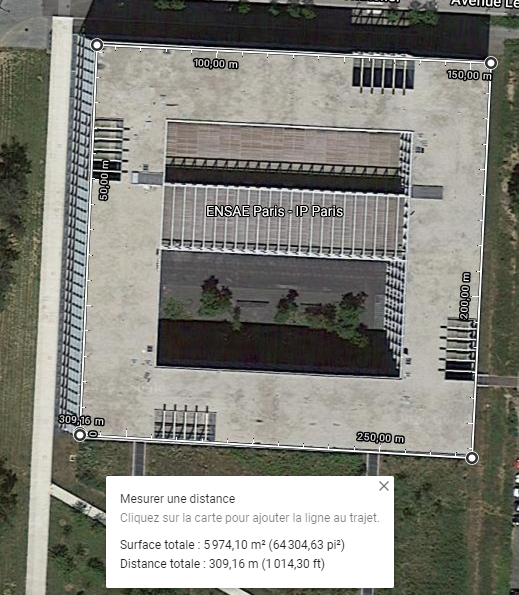

*Capture de Google Maps : la surface au sol du bâtiment de l'ENSAE est de $5 974 m^2$, soit 5,8 fois moins qu'un feu de forêt moyen.*








*   **Matrice de corrélation**







Text(0.5, 1.0, 'Matrice des corrélations entre conditions météorologiques et superficie des feux')

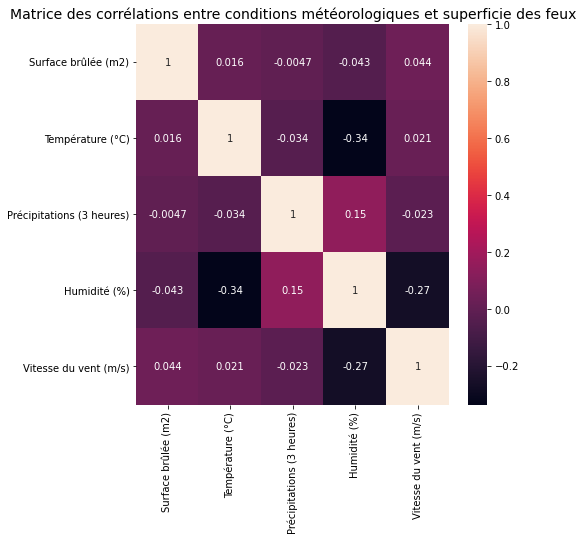

In [84]:
val = df_feu_correl.corr()
plt.figure(figsize = (7,7))
matrice2 = sns.heatmap(val, annot = True)
matrice2.set_title("Matrice des corrélations entre conditions météorologiques et superficie des feux",fontsize=14)

Encore une fois, les corrélations sont faibles. En effet, par exemple pour la température, quasiment tous les feux ont lieu à des températures équivalentes, mais on veut voir si ça a tendance à augmenter ou diminuer la surface brûlée (même légèrement).

En s'appuyant sur la première colonne,  on s'aperçoit que nos intuitions sont confirmés : 


*   Plus il fait chaud, plus la surface brûlée est grande, et donc plus l'incendie est dévastateur. 

*   Plus il a plu dans les 3 dernières heures ou plus l'air est humide, moins l'incendie se propage. La surface brûlée est alors plus petite. 

*   Plus la vitesse du vent est élevée, plus l'incendie se propage facilement. La surface brûlée est plus importante. 

**La vitesse du vent et l'humidité sont les variables météorologiques les plus fortement corrélées avec la surface brûlée.**

Même si le vent n'était pas fortement associé à un départ d'un feu dans la partie B, il joue un rôle très important dans la propagation de l'incendie, et donc dans sa gravité. L'humidité, quant à elle, est importante autant dans le déclenchement du feu que dans sa propagation.


Les corrélations entre conditions météorologiques sont différentes de celles obtenues dans la première matrice de corrélation car elles s'appuient sur une base de données différentes.

# Conclusion de la partie 2 

L'analyse descriptive des données et leur représentation graphique nous a ainsi permis de mettre en avant l'importance des conditions météorologiques dans le départ puis la propagation d'un feu de forêt. 

**La température et l'humidité** sont ainsi les données météo les plus corrélées au **déclenchement de l'incendie**, tandis que la **propagation du feu**, une fois celui-ci déclenché, est plutôt corrélée à **la vitesse du vent et l'humidité.** 
